In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

plt.rcParams["font.size"] = 16

file_path = '../results/ablation.csv'

x_dict = {'4096_14336_8': 'Mixtral-8x7B', 
        '2304_5760_8': 'MiniCPM-MoE', 
        '4096_11008_8': 'MiniCPM',
        '6144_16384_8': 'Mixtral-8x22B', 
        '2048_8192_32': 'OpenMoE-8B',
        '3072_12288_32': 'OpenMoE-34B',
        '2048_1408_64': 'DeepSeek-MoE',
        '2048_1408_60': 'Qwen2-MoE'
        }

order = ['MiniCPM-MoE', 'OpenMoE-34B', 'Mixtral-8x7B', 'Mixtral-8x22B', 'Qwen2-MoE', 'DeepSeek-MoE']

df = pd.read_csv(file_path)

In [10]:
def select_data(df, para_lists=[(4096,14336,8), (2304,5760,8), (6144,16384,8), (2048,8192,32), (3072,12288,32), (2048,1408,64), (2048,1408,60)]):
    data = {}

    for index, row in df.iterrows():
        batch_size = row['batch_size']
        hidden_size = row['hidden_size']
        intermediate_size = row['intermediate_size']
        kernel_type = row['Model']
        time = row['Time(ms)']
        expert_num = row['experts']
        
        if (hidden_size, intermediate_size, expert_num) not in para_lists:
            continue

        name = f"{hidden_size}_{intermediate_size}_{expert_num}"

        if name not in data:
            data[name] = {'MoEBlock': 0, 'SPMoEBlock': 0, 'SSDenseMoEBlock': 0, 'SSDenseTransMoEBlock': 0, 'SSDenseFuseTransMoEBlock': 0}

        if kernel_type == 'MoEBlock':
            data[name]['MoEBlock'] = time
        elif kernel_type == 'SPMoEBlock':
            data[name]['SPMoEBlock'] = time
        elif kernel_type == 'SSDenseMoEBlock':
            data[name]['SSDenseMoEBlock'] = time
        elif kernel_type == 'SSDenseTransMoEBlock':
            data[name]['SSDenseTransMoEBlock'] = time
        elif kernel_type == 'SSDenseFuseTransMoEBlock':
            data[name]['SSDenseFuseTransMoEBlock'] = time   

    data_array = [[x_dict[name]] + list(values.values()) for name, values in data.items()]
    
    return data_array

[['Mixtral-8x7B', 8963.214635848999, 5811.601161956787, 5671.611547470093, 5328.490972518921, 5019.80447769165], ['Mixtral-8x22B', 7663.06209564209, 7633.38565826416, 7478.887319564819, 7215.062141418457, 7161.602973937988], ['MiniCPM-MoE', 10428.835391998293, 7378.789901733398, 6637.5572681427, 6061.332702636719, 5647.924900054932], ['OpenMoE-34B', 7697.884798049927, 5181.246280670166, 5132.2174072265625, 4707.2083950042725, 4772.380828857422], ['DeepSeek-MoE', 8235.404968261719, 7496.367216110229, 6193.787336349487, 5639.137744903564, 5310.034990310669], ['Qwen2-MoE', 8248.41046333313, 7475.724458694458, 6083.489179611206, 5740.537643432617, 5550.282955169678]]


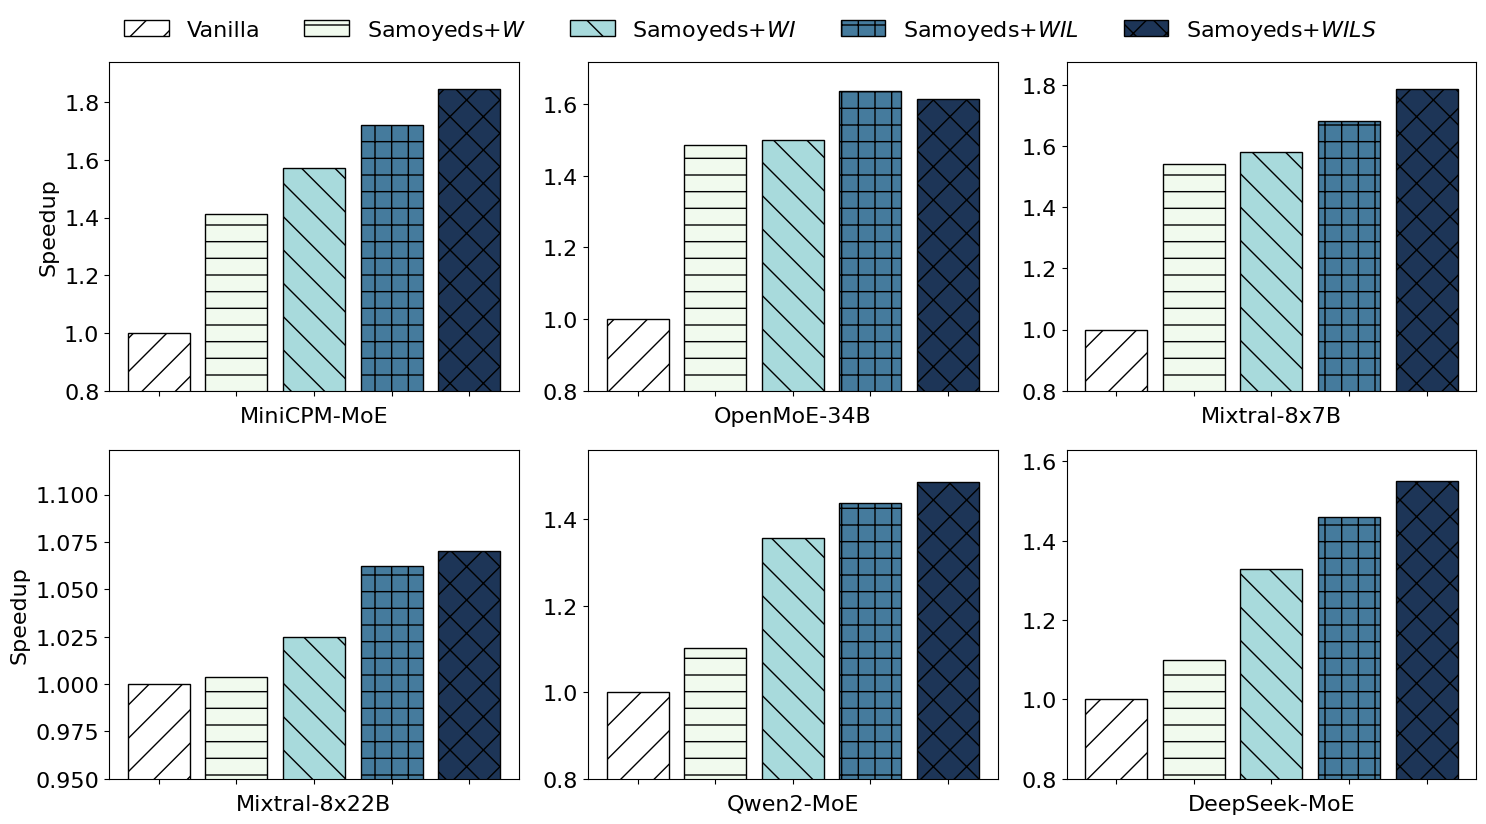

In [11]:
data_array = select_data(df, para_lists=[(4096,14336,8), (6144,16384,8), (2304,5760,8), (3072,12288,32), (2048,1408,64), (2048,1408,60)])
print(data_array)

data_df = pd.DataFrame(data_array, columns=['name', 'MoEBlock', 'SPMoEBlock', 'SSDenseMoEBlock', 'SSDenseTransMoEBlock', 'SSDenseFuseTransMoEBlock'])

data_df['SPMoEBlock'] = data_df['MoEBlock'] / data_df['SPMoEBlock']
data_df['SSDenseMoEBlock'] = data_df['MoEBlock'] / data_df['SSDenseMoEBlock']
data_df['SSDenseTransMoEBlock'] = data_df['MoEBlock'] / data_df['SSDenseTransMoEBlock']
data_df['SSDenseFuseTransMoEBlock'] = data_df['MoEBlock'] / data_df['SSDenseFuseTransMoEBlock']
data_df['MoEBlock'] = data_df['MoEBlock'] / data_df['MoEBlock'] 

name_mapping = {'MoEBlock': 'Vanilla', 'SPMoEBlock': 'Samoyeds+$W$', 'SSDenseMoEBlock': 'Samoyeds+$WI$', 'SSDenseTransMoEBlock': 'Samoyeds+$WIL$', 'SSDenseFuseTransMoEBlock': 'Samoyeds+$WILS$'}
data_df = data_df.rename(columns=name_mapping)

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

colors = ['#ffffff', '#f1faee', '#a8dadc', '#457b9d', '#1d3557']

name_mapping = {'MiniCPM-MoE': (0,0), 'OpenMoE-34B': (0,1), 'Mixtral-8x7B': (0,2), 'Mixtral-8x22B': (1,0), 'Qwen2-MoE': (1,1), 'DeepSeek-MoE': (1,2)}
for index, row in data_df.iterrows():
    model_name = row['name']
    row.pop('name')
    
    row_idx, col_idx = name_mapping[model_name]
    
    axs[row_idx, col_idx].bar(row.index, row, color=colors, edgecolor='black', label=row.index)
    
    if row_idx == 0 and col_idx == 0:
        handles, labels = axs[row_idx, col_idx].get_legend_handles_labels()  
        
    axs[row_idx, col_idx].set_xticklabels([]) 

    hatches = ['/', '-', '\\', '+', 'x'] 
    color_to_hatch = dict(zip(colors, hatches))
    for i, bar in enumerate(axs[row_idx, col_idx].patches):
        hex_color = mcolors.to_hex(bar.get_facecolor())
        bar.set_hatch(color_to_hatch[hex_color])

    axs[row_idx, col_idx].set_ylim([0.8, axs[row_idx, col_idx].get_ylim()[1]])
    if row_idx == 1 and col_idx == 0:
        axs[row_idx, col_idx].set_ylim([0.95, axs[row_idx, col_idx].get_ylim()[1]])
    
    if col_idx == 0:
        axs[row_idx, col_idx].set_ylabel("Speedup")
    
    axs[row_idx, col_idx].set_xlabel(model_name)


fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.97), ncol=5, frameon=False) 

plt.tight_layout()

plt.show()